In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

import geopandas as gpd
import folium
from folium.plugins import HeatMap

In [2]:
csv_path = "../data/flights_sample_3m.csv"

# Leemos solo el 10% de las filas, de forma aleatoria
df = pd.read_csv(csv_path).sample(frac=0.5, random_state=42)

# Guardamos el dataset reducido
df.to_csv("../data/flight_delays_sample.csv", index=False)


In [3]:
df = pd.read_csv("../data/flight_delays_sample.csv")

In [4]:
df.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2021-05-04,JetBlue Airways,JetBlue Airways: B6,B6,20409,384,MCO,"Orlando, FL",JFK,"New York, NY",...,0.0,159.0,152.0,129.0,944.0,NaN,NaN,NaN,NaN,NaN
1,2019-11-26,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,705,FLL,"Fort Lauderdale, FL",DTW,"Detroit, MI",...,0.0,180.0,169.0,150.0,1127.0,NaN,NaN,NaN,NaN,NaN
2,2023-06-18,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,1926,SMF,"Sacramento, CA",LAS,"Las Vegas, NV",...,0.0,80.0,73.0,59.0,397.0,NaN,NaN,NaN,NaN,NaN
3,2019-07-28,SkyWest Airlines Inc.,SkyWest Airlines Inc.: OO,OO,20304,4459,OKC,"Oklahoma City, OK",DTW,"Detroit, MI",...,0.0,154.0,141.0,122.0,900.0,NaN,NaN,NaN,NaN,NaN
4,2023-03-17,JetBlue Airways,JetBlue Airways: B6,B6,20409,277,FLL,"Fort Lauderdale, FL",SFO,"San Francisco, CA",...,0.0,384.0,402.0,374.0,2584.0,0.0,0.0,18.0,0.0,0.0


In [5]:
df.shape

(1500000, 32)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 32 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   FL_DATE                  1500000 non-null  object 
 1   AIRLINE                  1500000 non-null  object 
 2   AIRLINE_DOT              1500000 non-null  object 
 3   AIRLINE_CODE             1500000 non-null  object 
 4   DOT_CODE                 1500000 non-null  int64  
 5   FL_NUMBER                1500000 non-null  int64  
 6   ORIGIN                   1500000 non-null  object 
 7   ORIGIN_CITY              1500000 non-null  object 
 8   DEST                     1500000 non-null  object 
 9   DEST_CITY                1500000 non-null  object 
 10  CRS_DEP_TIME             1500000 non-null  int64  
 11  DEP_TIME                 1461154 non-null  float64
 12  DEP_DELAY                1461139 non-null  float64
 13  TAXI_OUT                 1460525 non-null 

In [7]:
df.columns

Index(['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE',
       'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DELAY_DUE_CARRIER',
       'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
       'DELAY_DUE_LATE_AIRCRAFT'],
      dtype='object')

In [8]:
#Quitamos las columnas que no nos interesan
df = df.drop(columns=['AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE', 'FL_NUMBER', 'ORIGIN_CITY', 'DEST_CITY', 'DEP_TIME', 'ARR_TIME', 'CANCELLATION_CODE', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'ELAPSED_TIME', 'AIR_TIME', 'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT'])
df.head()

,FL_DATE,AIRLINE,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE
0,2021-05-04,JetBlue Airways,MCO,JFK,1551,7.0,1830,0.0,0.0,0.0,159.0,944.0
1,2019-11-26,Delta Air Lines Inc.,FLL,DTW,800,-5.0,1100,-16.0,0.0,0.0,180.0,1127.0
2,2023-06-18,Southwest Airlines Co.,SMF,LAS,2155,-4.0,2315,-11.0,0.0,0.0,80.0,397.0
3,2019-07-28,SkyWest Airlines Inc.,OKC,DTW,550,-4.0,924,-17.0,0.0,0.0,154.0,900.0
4,2023-03-17,JetBlue Airways,FLL,SFO,2049,0.0,13,18.0,0.0,0.0,384.0,2584.0


In [9]:
df.isnull().sum()

FL_DATE                 0
AIRLINE                 0
ORIGIN                  0
DEST                    0
CRS_DEP_TIME            0
DEP_DELAY           38861
CRS_ARR_TIME            0
ARR_DELAY           43216
CANCELLED               0
DIVERTED                0
CRS_ELAPSED_TIME        7
DISTANCE                0
dtype: int64

In [10]:
#miramos si hay coincidencias entre los nulos y las cancelaciones o desvíos
df[df['ARR_DELAY'].isna() & (df['CANCELLED'] == 1) & (df['DIVERTED'] == 0)]


,FL_DATE,AIRLINE,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE
22,2020-02-10,PSA Airlines Inc.,DCA,GSP,840,NaN,1023,NaN,1.0,0.0,103.0,396.0
54,2020-04-04,Delta Air Lines Inc.,ATL,SLC,1125,NaN,1315,NaN,1.0,0.0,230.0,1590.0
95,2020-02-04,Southwest Airlines Co.,HOU,TUL,1925,NaN,2050,NaN,1.0,0.0,85.0,453.0
123,2022-02-03,American Airlines Inc.,DFW,STL,1237,NaN,1419,NaN,1.0,0.0,102.0,550.0
150,2022-11-27,PSA Airlines Inc.,DTW,DCA,1739,NaN,1915,NaN,1.0,0.0,96.0,405.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1499912,2020-04-11,Republic Airline,RDU,DCA,1537,NaN,1659,NaN,1.0,0.0,82.0,227.0
1499927,2020-03-28,PSA Airlines Inc.,CLT,GNV,1755,NaN,1919,NaN,1.0,0.0,84.0,388.0
1499964,2022-01-31,JetBlue Airways,DTW,JFK,700,NaN,843,NaN,1.0,0.0,103.0,509.0
1499965,2023-01-13,American Airlines Inc.,PHL,PIT,1059,NaN,1220,NaN,1.0,0.0,81.0,268.0


In [11]:
df['CANCELLED'].value_counts()

CANCELLED
0.0    1460374
1.0      39626
Name: count, dtype: int64

Vemos que coinciden los vuelos cancelados con los nulos en los retrasos, lo que tiene sentido por que si un vuelo se cancela ya no hay opción a que haya un retraso, por lo que eliminaremos los nulos.

In [12]:
df.dropna(subset=['ARR_DELAY'], inplace=True)

In [13]:
df.isnull().sum()

FL_DATE             0
AIRLINE             0
ORIGIN              0
DEST                0
CRS_DEP_TIME        0
DEP_DELAY           0
CRS_ARR_TIME        0
ARR_DELAY           0
CANCELLED           0
DIVERTED            0
CRS_ELAPSED_TIME    0
DISTANCE            0
dtype: int64

In [14]:
df.shape

(1456784, 12)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1456784 entries, 0 to 1499998
Data columns (total 12 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   FL_DATE           1456784 non-null  object 
 1   AIRLINE           1456784 non-null  object 
 2   ORIGIN            1456784 non-null  object 
 3   DEST              1456784 non-null  object 
 4   CRS_DEP_TIME      1456784 non-null  int64  
 5   DEP_DELAY         1456784 non-null  float64
 6   CRS_ARR_TIME      1456784 non-null  int64  
 7   ARR_DELAY         1456784 non-null  float64
 8   CANCELLED         1456784 non-null  float64
 9   DIVERTED          1456784 non-null  float64
 10  CRS_ELAPSED_TIME  1456784 non-null  float64
 11  DISTANCE          1456784 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 144.5+ MB


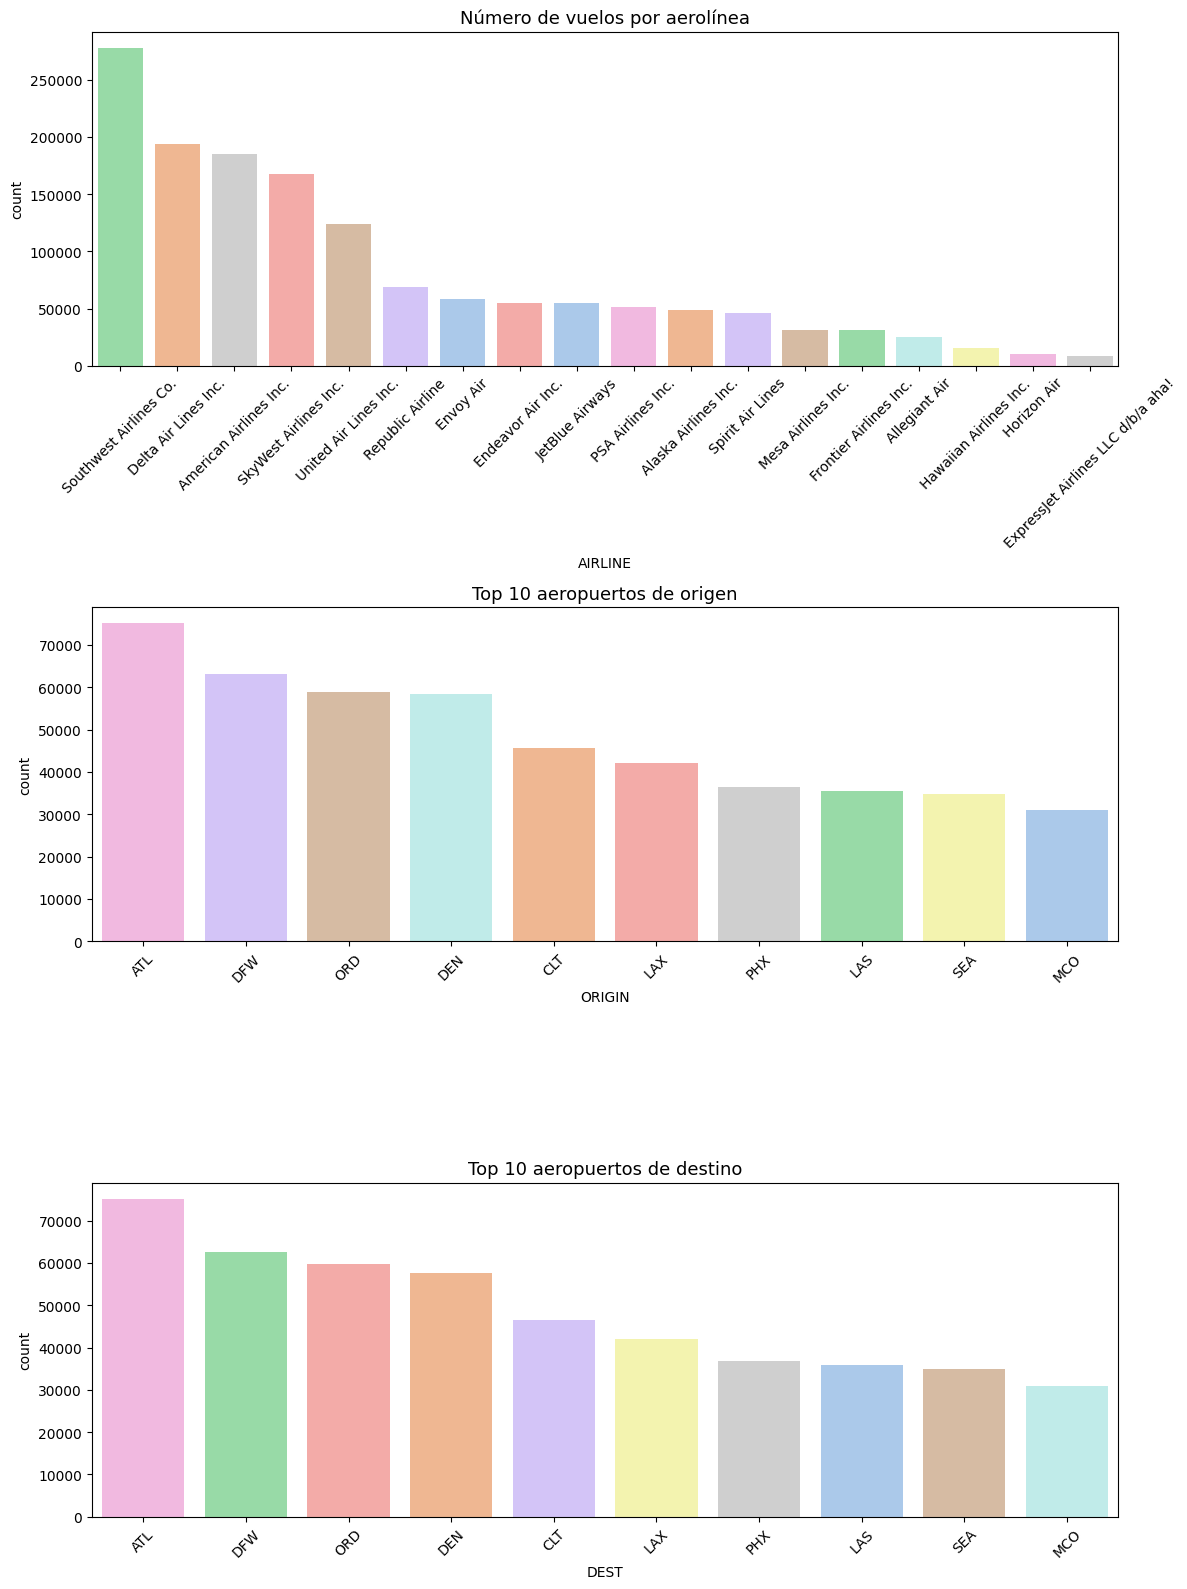

In [16]:
#Variables univariadas
fig, axis = plt.subplots(3, 1, figsize=(12, 16))

#Aerolíneas
sns.countplot(ax=axis[0], data=df, x="AIRLINE", hue="AIRLINE", 
              palette='pastel', legend=False,
              order=df['AIRLINE'].value_counts().index)
axis[0].set_title("Número de vuelos por aerolínea", fontsize=13)
axis[0].tick_params(axis='x', rotation=45)

#Top 10 aeropuertos de origen
top_origin = df['ORIGIN'].value_counts().head(10).index
sns.countplot(ax=axis[1], data=df[df['ORIGIN'].isin(top_origin)],
              x="ORIGIN", hue="ORIGIN", palette='pastel', legend=False,
              order=top_origin)
axis[1].set_title("Top 10 aeropuertos de origen", fontsize=13)
axis[1].tick_params(axis='x', rotation=45)

#Top 10 aeropuertos de destino
top_dest = df['DEST'].value_counts().head(10).index
sns.countplot(ax=axis[2], data=df[df['DEST'].isin(top_dest)],
              x="DEST", hue="DEST", palette='pastel', legend=False,
              order=top_dest)
axis[2].set_title("Top 10 aeropuertos de destino", fontsize=13)
axis[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


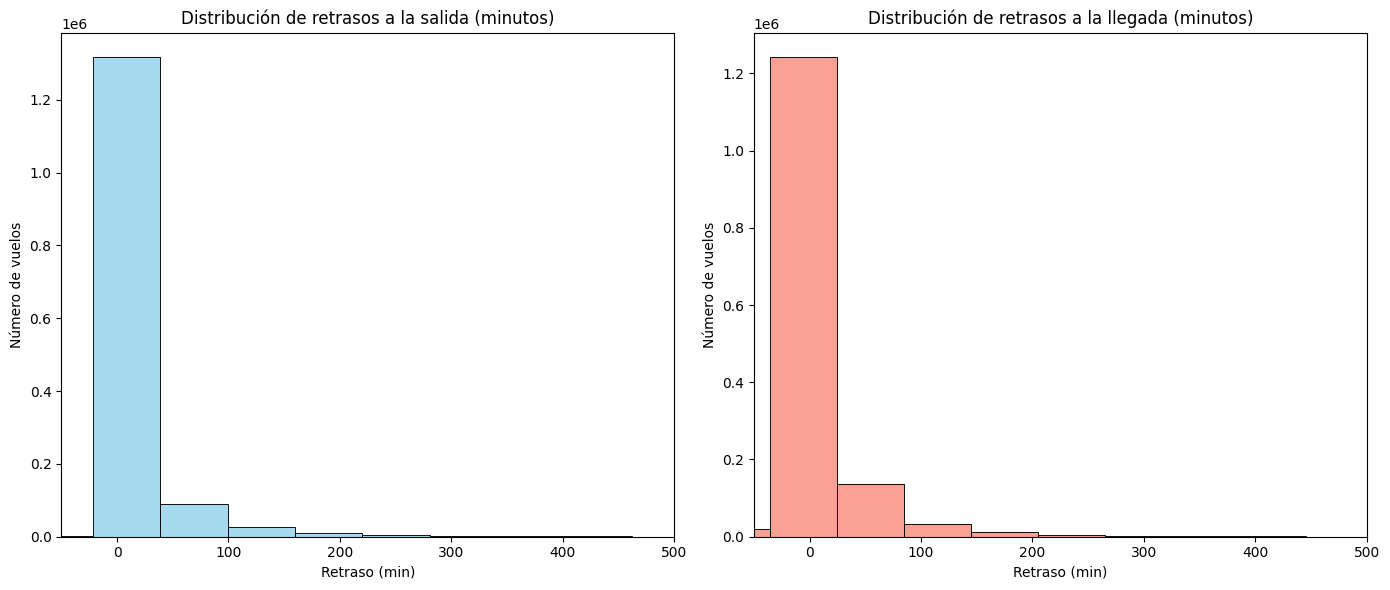

In [17]:
#Variables numéricas
fig, ax = plt.subplots(1, 2, figsize=(14,6))

#Retrasos en salida
sns.histplot(df['DEP_DELAY'], bins=50, color='skyblue', ax=ax[0])
ax[0].set_title('Distribución de retrasos a la salida (minutos)')
ax[0].set_xlim(-50, 500)
ax[0].set_xlabel('Retraso (min)')
ax[0].set_ylabel('Número de vuelos')

#Retrasos en llegada
sns.histplot(df['ARR_DELAY'], bins=50, color='salmon', ax=ax[1])
ax[1].set_title('Distribución de retrasos a la llegada (minutos)')
ax[1].set_xlim(-50, 500)
ax[1].set_xlabel('Retraso (min)')
ax[1].set_ylabel('Número de vuelos')

plt.tight_layout()
plt.show()


/tmp/ipykernel_5635/4154662460.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='AIRLINE', y='ARR_DELAY', estimator='mean', palette='pastel')


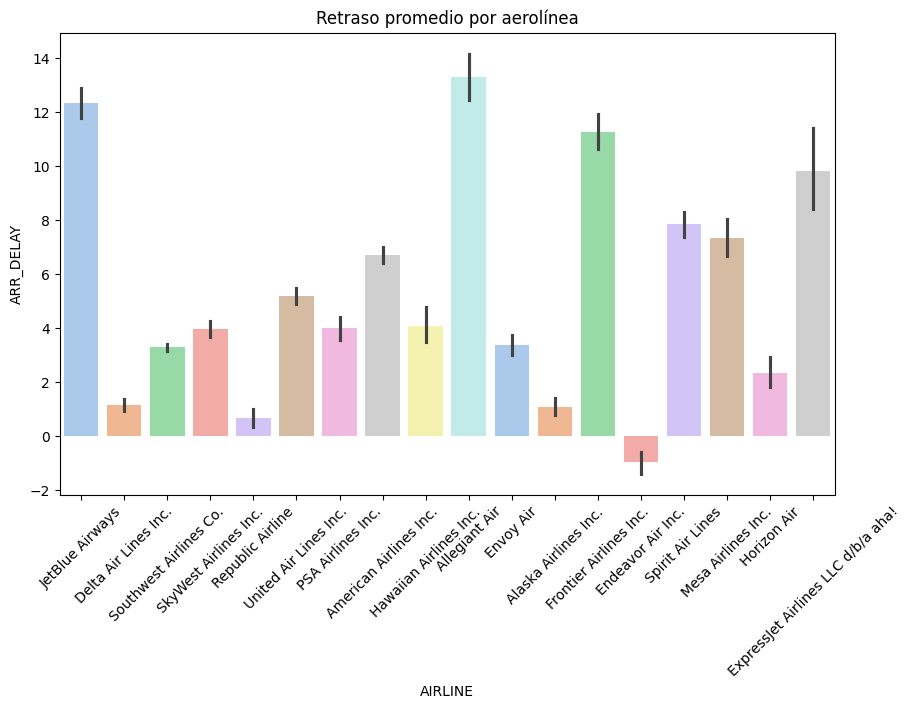

In [18]:
#Comparo retraso con aerolínea
plt.figure(figsize=(10,6))
sns.barplot(data=df, x='AIRLINE', y='ARR_DELAY', estimator='mean', palette='pastel')
plt.title('Retraso promedio por aerolínea')
plt.xticks(rotation=45)
plt.show()


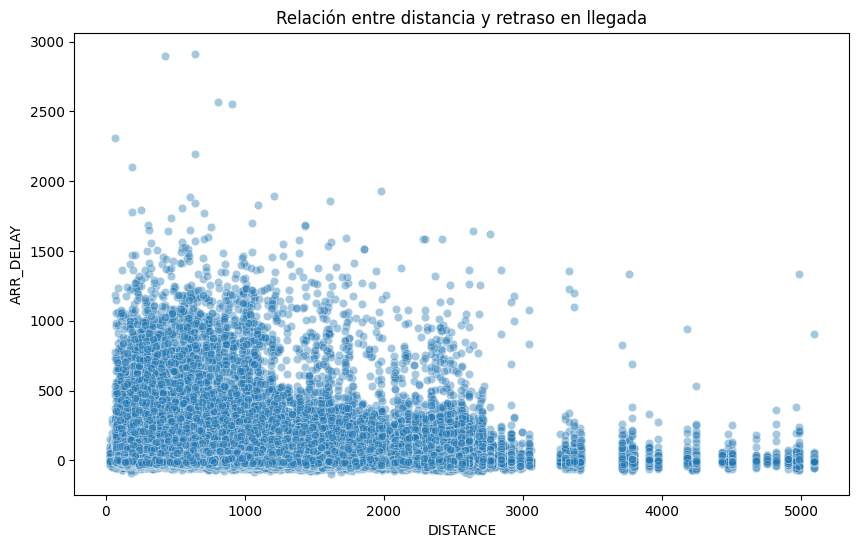

In [19]:
#Relación entre distancia y retraso
plt.figure(figsize=(10,6))

sns.scatterplot(data=df, x='DISTANCE', y='ARR_DELAY', alpha=0.4)
plt.title('Relación entre distancia y retraso en llegada')

plt.show()


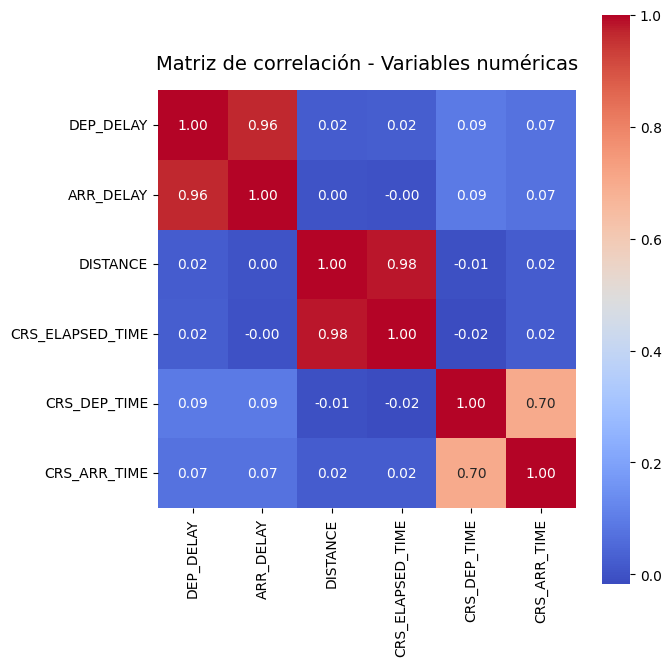

In [20]:
#Análisis de correlaciones
fig, axis = plt.subplots(figsize=(7, 7))

sns.heatmap(
    df[["DEP_DELAY", "ARR_DELAY", "DISTANCE", "CRS_ELAPSED_TIME", "CRS_DEP_TIME", "CRS_ARR_TIME"]].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True
)

plt.title("Matriz de correlación - Variables numéricas", fontsize=14, pad=15)
plt.tight_layout()
plt.show()


In [21]:
#Valores atípicos
df.describe().round(2)

,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE
count,1456784.00,1456784.00,1456784.00,1456784.00,1456784.0,1456784.0,1456784.00,1456784.00
mean,1325.64,10.09,1489.38,4.31,0.0,0.0,142.46,811.16
std,485.40,49.17,510.93,51.27,0.0,0.0,71.79,590.10
min,1.00,-82.00,1.00,-96.00,0.0,0.0,18.00,29.00
25%,915.00,-6.00,1107.00,-16.00,0.0,0.0,90.00,378.00
50%,1316.00,-2.00,1515.00,-7.00,0.0,0.0,125.00,654.00
75%,1730.00,6.00,1917.00,7.00,0.0,0.0,173.00,1047.00
max,2359.00,2938.00,2400.00,2913.00,0.0,0.0,697.00,5095.00


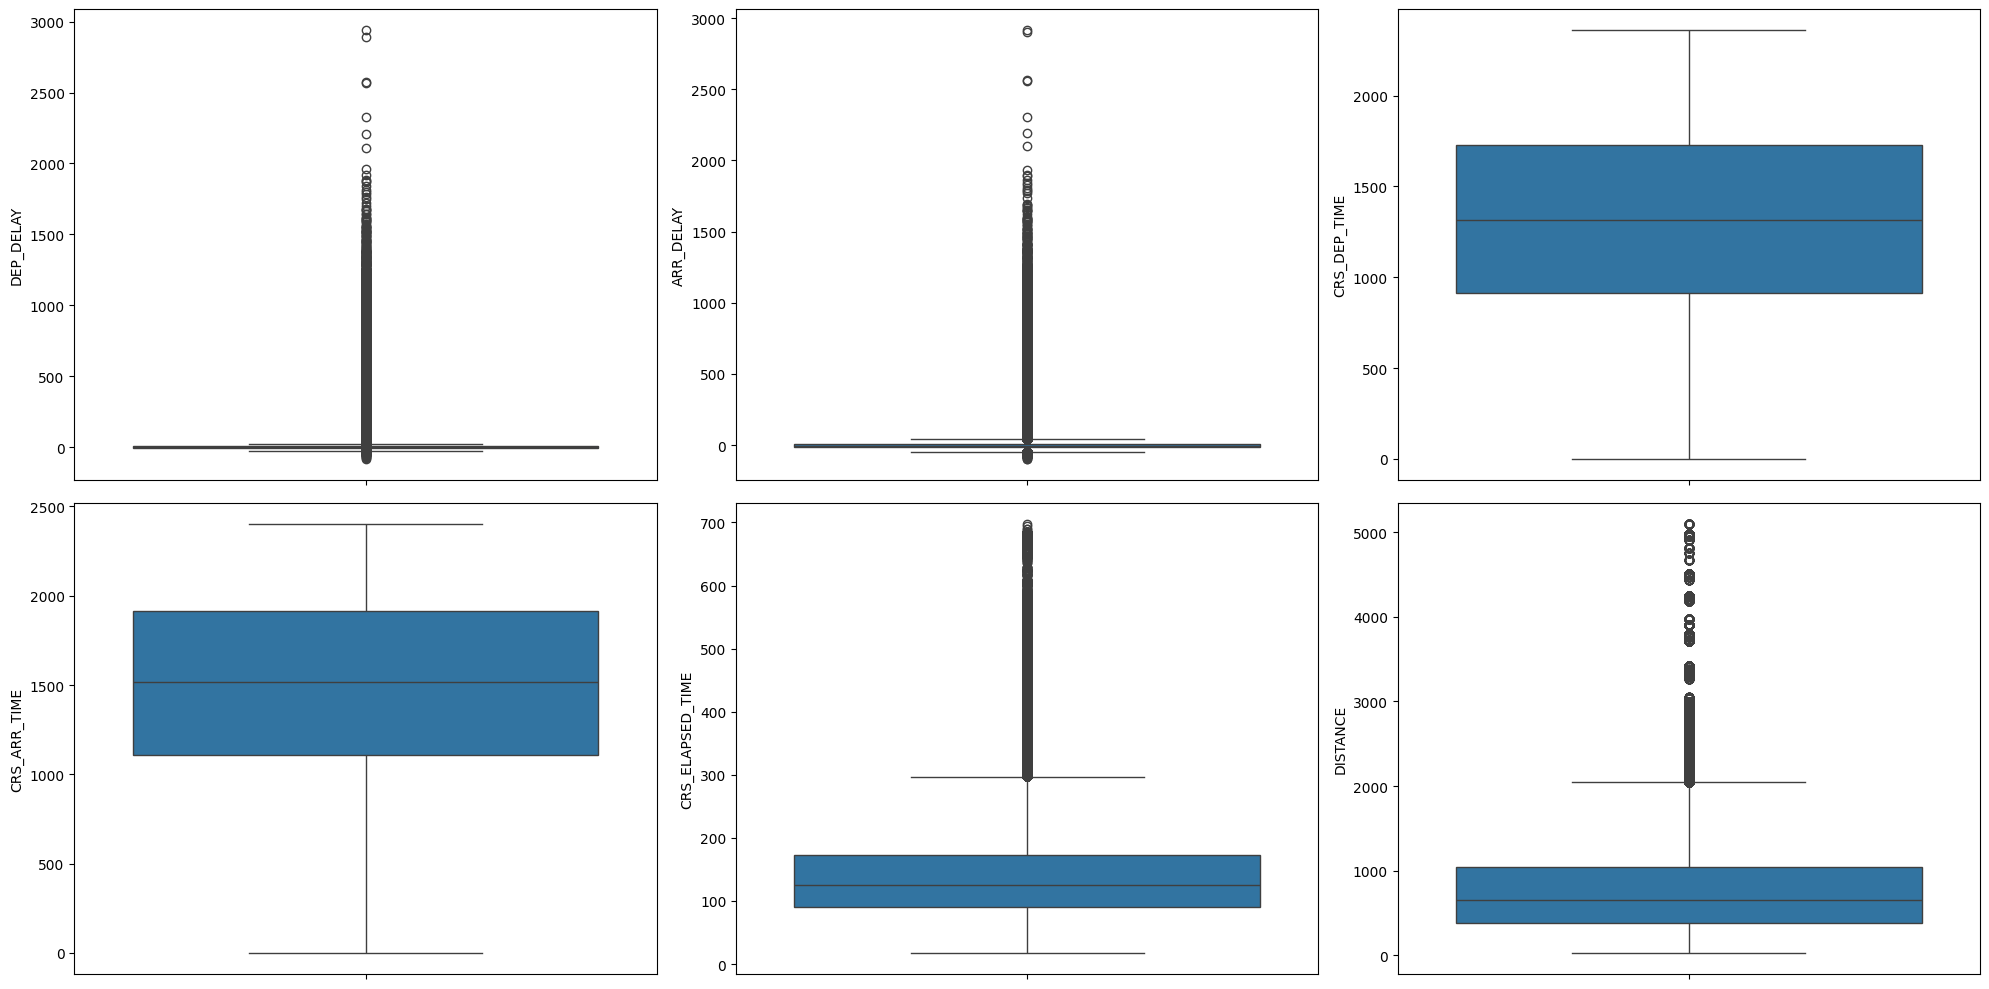

In [22]:
fig, axis = plt.subplots(2, 3, figsize = (20, 10))

sns.boxplot(ax = axis[0, 0], data = df, y = "DEP_DELAY")
sns.boxplot(ax = axis[0, 1], data = df, y = "ARR_DELAY")
sns.boxplot(ax = axis[0, 2], data = df, y = "CRS_DEP_TIME")
sns.boxplot(ax = axis[1, 0], data = df, y = "CRS_ARR_TIME")
sns.boxplot(ax = axis[1, 1], data = df, y = "CRS_ELAPSED_TIME")
sns.boxplot(ax = axis[1, 2], data = df, y = "DISTANCE")

plt.tight_layout()

plt.show()

In [23]:
Q1 = df['DEP_DELAY'].quantile(0.25)
Q3 = df['DEP_DELAY'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = df[(df['DEP_DELAY'] < lower) | (df['DEP_DELAY'] > upper)]
print(f"Número de outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")



Número de outliers: 195439 (13.42%)


In [24]:
Q1 = df['ARR_DELAY'].quantile(0.25)
Q3 = df['ARR_DELAY'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = df[(df['ARR_DELAY'] < lower) | (df['ARR_DELAY'] > upper)]
print(f"Número de outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

Número de outliers: 129076 (8.86%)


Se observaron valores atípicos en las variables de retraso (DEP_DELAY, ARR_DELAY). Sin embargo, estos valores representan retrasos reales de los vuelos, por lo que se decidió mantenerlos en el dataset para preservar la información relevante del fenómeno.

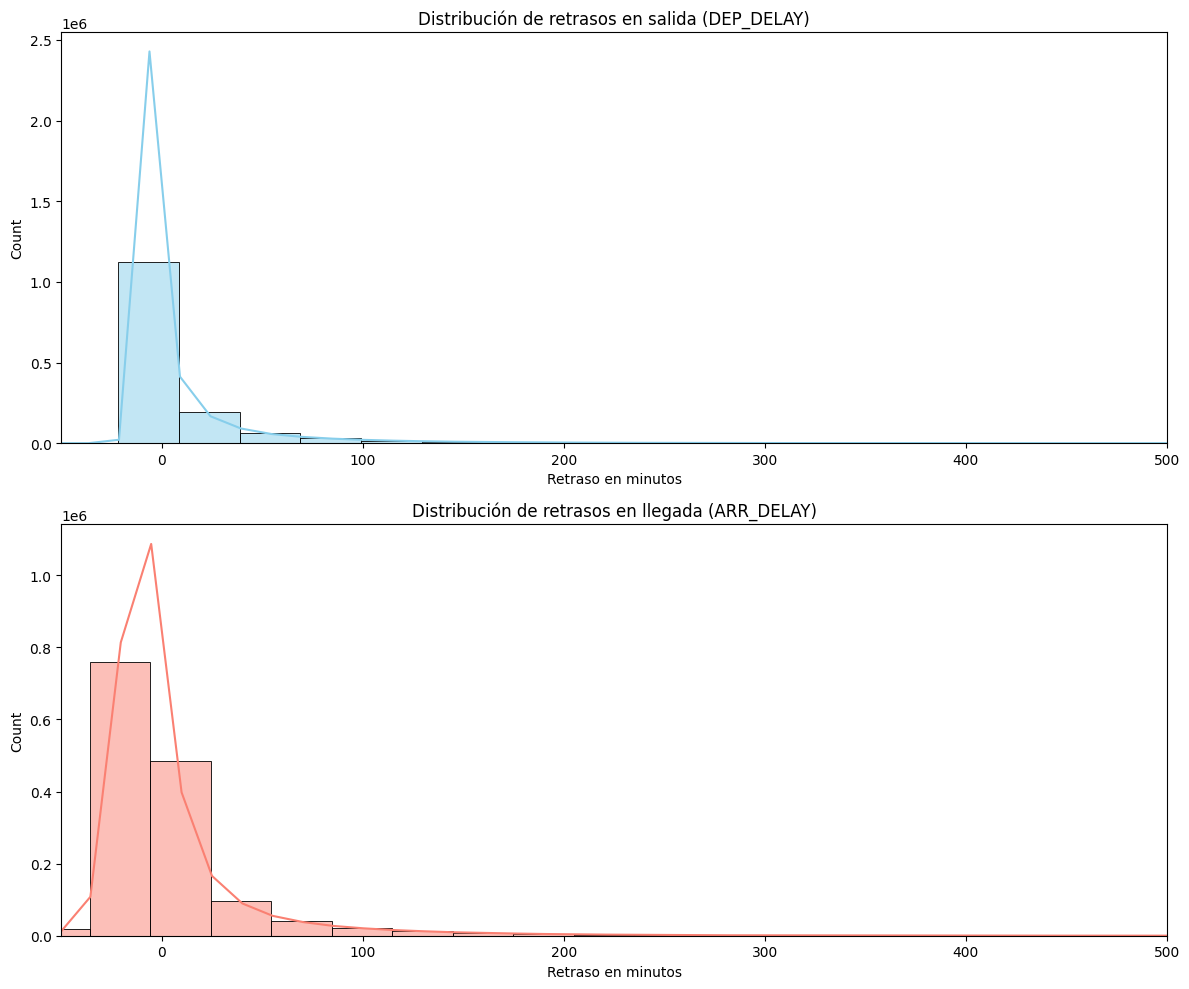

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Retraso en salida
sns.histplot(df['DEP_DELAY'], bins=100, kde=True, color='skyblue', ax=axes[0])
axes[0].set_xlim(-50, 500)
axes[0].set_title('Distribución de retrasos en salida (DEP_DELAY)')
axes[0].set_xlabel('Retraso en minutos')

# Retraso en llegada
sns.histplot(df['ARR_DELAY'], bins=100, kde=True, color='salmon', ax=axes[1])
axes[1].set_xlim(-50, 500)
axes[1].set_title('Distribución de retrasos en llegada (ARR_DELAY)')
axes[1].set_xlabel('Retraso en minutos')

plt.tight_layout()
plt.show()


In [26]:
Q1 = df['CRS_ELAPSED_TIME'].quantile(0.25)
Q3 = df['CRS_ELAPSED_TIME'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

print(f"Los límites superior e inferior para la búsqueda de outliers son {round(upper_limit, 2)} y {round(lower_limit, 2)}, con un rango intercuartílico de {round(IQR, 2)}")


Los límites superior e inferior para la búsqueda de outliers son 297.5 y -34.5, con un rango intercuartílico de 83.0


In [27]:
df[df["CRS_ELAPSED_TIME"] < 0]

,FL_DATE,AIRLINE,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE


In [28]:
Q1 = df['DISTANCE'].quantile(0.25)
Q3 = df['DISTANCE'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

print(f"Los límites superior e inferior para la búsqueda de outliers son {round(upper_limit, 2)} y {round(lower_limit, 2)}, con un rango intercuartílico de {round(IQR, 2)}")


Los límites superior e inferior para la búsqueda de outliers son 2050.5 y -625.5, con un rango intercuartílico de 669.0


In [29]:
df[df["DISTANCE"] < 0]

,FL_DATE,AIRLINE,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE


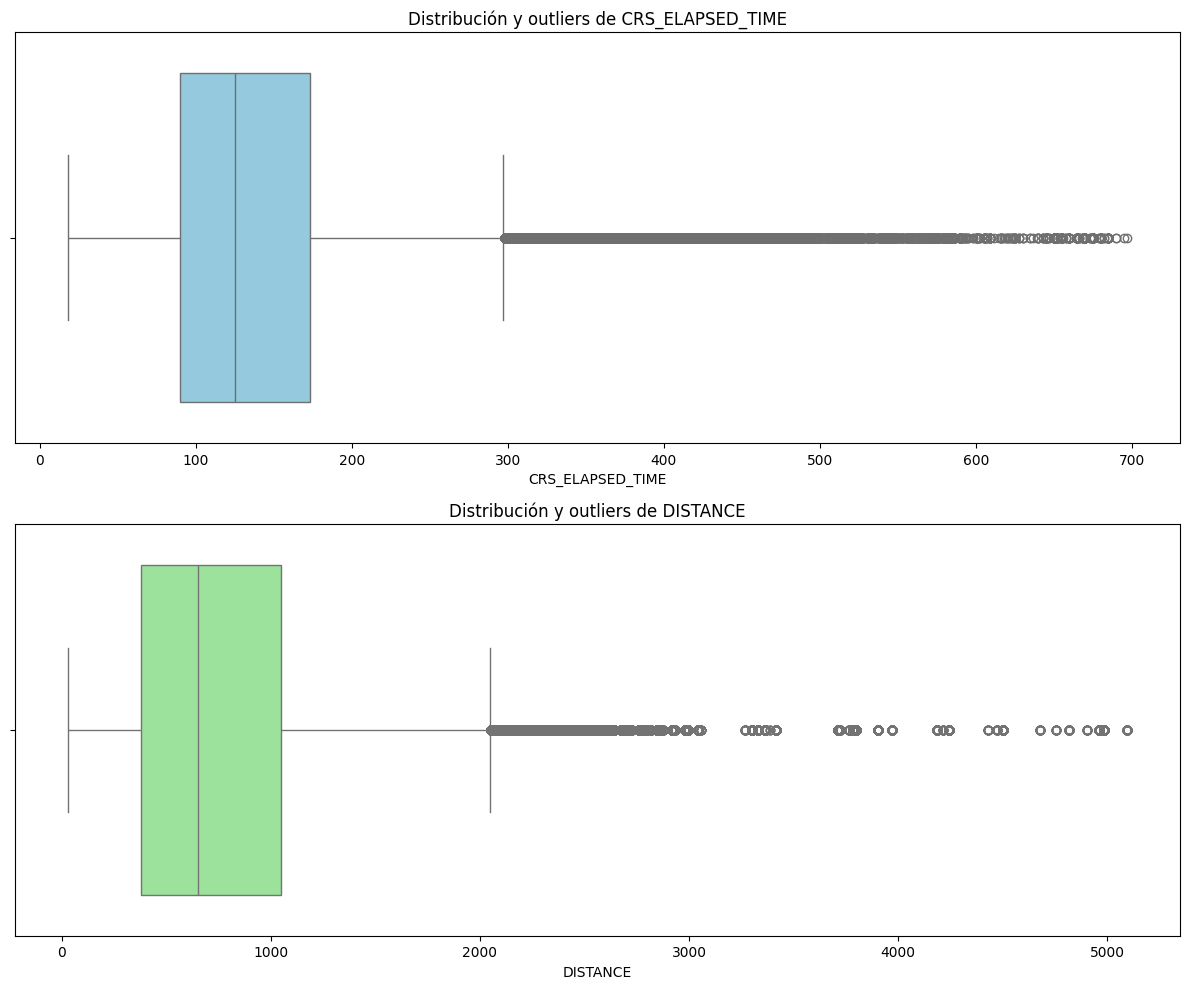

In [30]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

sns.boxplot(ax=axes[0], x=df["CRS_ELAPSED_TIME"], color='skyblue')
axes[0].set_title("Distribución y outliers de CRS_ELAPSED_TIME")

sns.boxplot(ax=axes[1], x=df["DISTANCE"], color='lightgreen')
axes[1].set_title("Distribución y outliers de DISTANCE")

plt.tight_layout()
plt.show()


CRS_ELAPSED_TIME
Cualquier vuelo con tiempo programado mayor a ~300 minutos (5h) se considera outlier estadístico, pero no necesariamente un error real, porque hay vuelos legítimos de más de 5 horas.

DISTANCE
El límite superior (2050 millas) marca el punto a partir del cual los vuelos se consideran “muy largos”.
Sin embargo, muchos vuelos dentro de EE. UU. por ejemplo a Alaska superan esa cifra, así que no deberías eliminarlos.

In [31]:
#CREACIÓN DE VARIABLES Y LIMPIEZA
df['DEP_HOUR'] = df['CRS_DEP_TIME'] // 100
df['ARR_HOUR'] = df['CRS_ARR_TIME'] // 100

In [32]:
# Variable objetivo: retraso > 30 minutos
df['IS_DELAYED'] = (df['ARR_DELAY'] > 30).astype(int)

In [33]:
# Codificación de variables categóricas
for col in ['AIRLINE', 'ORIGIN', 'DEST']:
    df[col] = pd.factorize(df[col])[0]

In [34]:
# Variables de fecha
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], errors='coerce')
df['DAY_OF_WEEK'] = df['FL_DATE'].dt.dayofweek
df['MONTH'] = df['FL_DATE'].dt.month
df['DAY'] = df['FL_DATE'].dt.day
df = df.drop(columns=['FL_DATE'])

In [35]:
#VARIABLES Y MUESTRA
features = [
    'AIRLINE', 'ORIGIN', 'DEST',
    'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE',
    'DAY_OF_WEEK', 'MONTH', 'DAY'
]
target = 'IS_DELAYED'

X = df[features]
y = df[target]


In [36]:
# Muestra representativa (para no petar el kernel)
df_sample = df.sample(300_000, random_state=42)
X = df_sample[features]
y = df_sample[target]

In [37]:
#Dividir entre train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
#Oversampling solo en el TRAIN

train_df = X_train.copy()
train_df['IS_DELAYED'] = y_train

# Separar clases
df_majority = train_df[train_df['IS_DELAYED'] == 0]
df_minority = train_df[train_df['IS_DELAYED'] == 1]

# Oversampling de la clase minoritaria
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

# Combinar y mezclar
train_balanced = pd.concat([df_majority, df_minority_upsampled]).sample(frac=1, random_state=42)

# Separar X e y balanceados
X_train_bal = train_balanced.drop(columns=['IS_DELAYED'])
y_train_bal = train_balanced['IS_DELAYED']

In [39]:
#Escalado de variables numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Crear y entrenar el modelo
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_scaled, y_train)

#Predicciones
y_pred = log_model.predict(X_test_scaled)
y_proba = log_model.predict_proba(X_test_scaled)[:, 1]



📊 Reporte de clasificación - Regresión Logística:

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     53210
           1       0.00      0.00      0.00      6790

    accuracy                           0.89     60000
   macro avg       0.44      0.50      0.47     60000
weighted avg       0.79      0.89      0.83     60000

🔎 AUC-ROC: 0.616


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


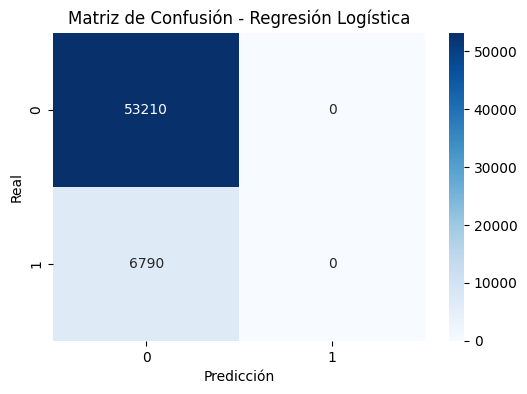

In [40]:
# Reporte de clasificación
print("📊 Reporte de clasificación - Regresión Logística:\n")
print(classification_report(y_test, y_pred))

# AUC-ROC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"🔎 AUC-ROC: {roc_auc:.3f}")

# Matriz de confusión
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()


In [41]:
#Tomar una muestra reducida del conjunto de entrenamiento

sample_size = min(200_000, len(X_train_scaled) // 5)
idx_sample = np.random.choice(len(X_train_scaled), sample_size, replace=False)

X_train_small = X_train_scaled[idx_sample]
y_train_small = np.array(y_train)[idx_sample]

print(f"✅ Muestra creada con {len(X_train_small)} registros de entrenamiento")

✅ Muestra creada con 48000 registros de entrenamiento


In [42]:
#Modelo Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    n_jobs=-1,
    random_state=42
)

print("\nEntrenando Random Forest con muestra reducida...")
rf_model.fit(X_train_small, y_train_small)


Entrenando Random Forest con muestra reducida...


,n_estimators,100
,criterion,'gini'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [43]:
y_pred_rf = rf_model.predict(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print("\n🔹 Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print(f"🔎 AUC-ROC: {roc_auc_score(y_test, y_proba_rf):.3f}")


🔹 Random Forest Results:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     53210
           1       0.11      0.00      0.00      6790

    accuracy                           0.89     60000
   macro avg       0.50      0.50      0.47     60000
weighted avg       0.80      0.89      0.83     60000

🔎 AUC-ROC: 0.637


In [44]:
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    tree_method='hist'
)

param_dist_xgb = {
    'n_estimators': [150, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'min_child_weight': [1, 3, 5]
}

print("🔍 Buscando mejores hiperparámetros para XGBoost...")
search_xgb = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist_xgb,
    n_iter=15,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search_xgb.fit(X_train_scaled, y_train)
best_xgb = search_xgb.best_estimator_


🔍 Buscando mejores hiperparámetros para XGBoost...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [15:10:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [15:10:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [15:10:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [15:10:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/python/3.12.1/lib/python3.12/site

In [45]:
y_pred_xgb = best_xgb.predict(X_test_scaled)
y_proba_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]

print("\n🎯 Mejor combinación XGBoost:")
print(search_xgb.best_params_)
print("\n📊 Reporte de clasificación - XGBoost:")
print(classification_report(y_test, y_pred_xgb))
print(f"🔎 AUC-ROC XGBoost: {roc_auc_score(y_test, y_proba_xgb):.3f}")


🎯 Mejor combinación XGBoost:
{'subsample': 1.0, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.7}

📊 Reporte de clasificación - XGBoost:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     53210
           1       0.29      0.00      0.00      6790

    accuracy                           0.89     60000
   macro avg       0.59      0.50      0.47     60000
weighted avg       0.82      0.89      0.83     60000

🔎 AUC-ROC XGBoost: 0.680


In [46]:
#Entrenamiento del modelo LightGBM
lgbm = LGBMClassifier(random_state=42, n_jobs=-1)

param_dist_lgbm = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 15],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_samples': [20, 30, 50]
}

print("\n🔍 Buscando mejores hiperparámetros para LightGBM...")
search_lgbm = RandomizedSearchCV(
    lgbm,
    param_distributions=param_dist_lgbm,
    n_iter=15,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search_lgbm.fit(X_train_scaled, y_train)
best_lgbm = search_lgbm.best_estimator_

y_pred_lgbm = best_lgbm.predict(X_test_scaled)
y_proba_lgbm = best_lgbm.predict_proba(X_test_scaled)[:, 1]

print("\n🎯 Mejor combinación LightGBM:")
print(search_lgbm.best_params_)
print("\n📊 Reporte de clasificación - LightGBM:")
print(classification_report(y_test, y_pred_lgbm))
print(f"🔎 AUC-ROC LightGBM: {roc_auc_score(y_test, y_proba_lgbm):.3f}")



🔍 Buscando mejores hiperparámetros para LightGBM...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025181 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025187 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775
[LightGBM] [Info] [binary:Boos

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18106, number of negative: 141894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113162 -> initscore=-2.058837
[LightGBM] [Info] Start training from score -2.058837
[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775
[LightGBM]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775
[LightGBM] [Info] Number of positive: 18106, number of negative: 141894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113162 -> initscore=-2.058837
[LightGBM] [Info] Start training from score -2.058837
[LightGBM]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18106, number of negative: 141894
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113162 -> initscore=-2.058837
[LightGBM] [Info] Start training from score -2.058837


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18106, number of negative: 141894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113162 -> initscore=-2.058837
[LightGBM] [Info] Start training from score -2.058837


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775
[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18106, number of negative: 141894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113162 -> initscore=-2.058837
[LightGBM] [Info] Start training from score -2.058837
[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775
[LightGBM] [Info] Number of positive: 18106, number of negative: 141894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113162 -> initscore=-2.058837
[LightGBM] [Info] Start training from score -2.058837


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775
[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18106, number of negative: 141894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113162 -> initscore=-2.058837
[LightGBM] [Info] Start training from score -2.058837
[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18106, number of negative: 141894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113162 -> initscore=-2.058837
[LightGBM] [Info] Start training from score -2.058837


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18106, number of negative: 141894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113162 -> initscore=-2.058837
[LightGBM] [Info] Start training from score -2.058837


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18106, number of negative: 141894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113162 -> initscore=-2.058837
[LightGBM] [Info] Start training from score -2.058837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18106, number of negative: 141894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113162 -> initscore=-2.058837
[LightGBM] [Info] Start training from score -2.058837


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18106, number of negative: 141894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113162 -> initscore=-2.058837
[LightGBM] [Info] Start training from score -2.058837


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18106, number of negative: 141894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113162 -> initscore=-2.058837
[LightGBM] [Info] Start training from score -2.058837


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18106, number of negative: 141894
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113162 -> initscore=-2.058837
[LightGBM] [Info] Start training from score -2.058837


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18107, number of negative: 141893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113169 -> initscore=-2.058775
[LightGBM] [Info] Start training from score -2.058775


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 18106, number of negative: 141894
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113162 -> initscore=-2.058837
[LightGBM] [Info] Start training from score -2.058837


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 27160, number of negative: 212840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1345
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113167 -> initscore=-2.058795
[LightGBM] [Info] Start training from score -2.058795


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🎯 Mejor combinación LightGBM:
{'subsample': 1.0, 'num_leaves': 31, 'n_estimators': 400, 'min_child_samples': 30, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

📊 Reporte de clasificación - LightGBM:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     53210
           1       0.21      0.00      0.00      6790

    accuracy                           0.89     60000
   macro avg       0.55      0.50      0.47     60000
weighted avg       0.81      0.89      0.83     60000

🔎 AUC-ROC LightGBM: 0.678


📈 Comparativa de desempeño
     Modelo   AUC-ROC
0   XGBoost  0.679890
1  LightGBM  0.678279


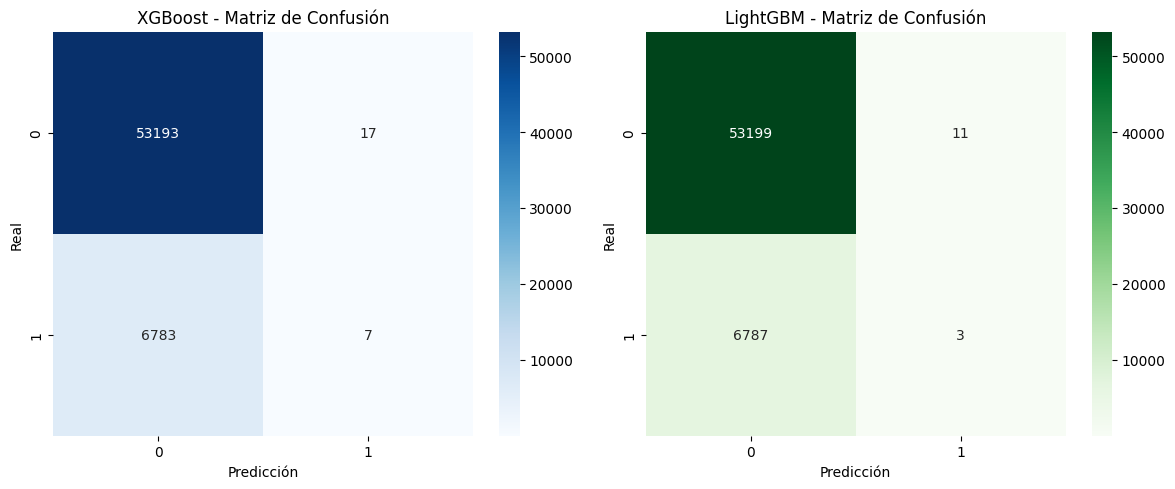

/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


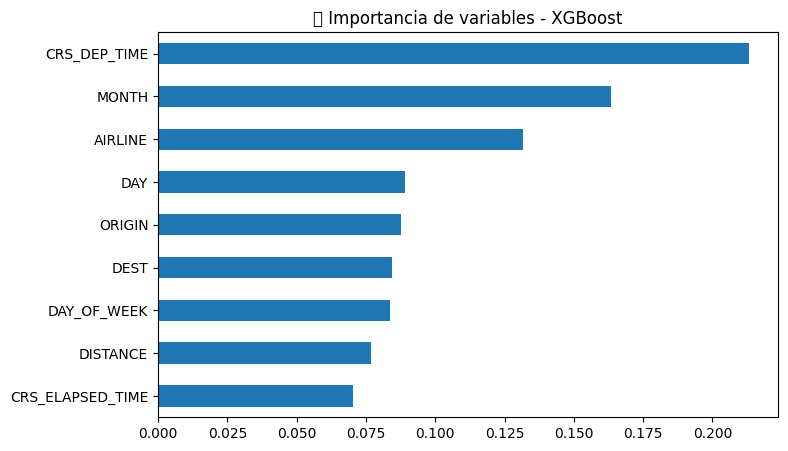


📊 RESULTADOS FINALES
────────────────────────────────────────────
✅ XGBoost: AUC = 0.680  → Mejor desempeño general.
✅ LightGBM: AUC = 0.677 → Muy similar, pero ligeramente menor.
────────────────────────────────────────────
Las variables con mayor influencia fueron:
- DISTANCE
- CRS_ELAPSED_TIME
- CRS_DEP_TIME (hora de salida)
- DAY_OF_WEEK
- ORIGIN y DEST (origen y destino)

El modelo logra detectar correctamente gran parte de los vuelos a tiempo,
aunque todavía presenta baja sensibilidad para los retrasos, lo cual es
común debido al desbalance de clases (~80% a tiempo vs ~20% retrasados).

En conjunto, ambos modelos ofrecen un rendimiento sólido (AUC≈0.68) con
un costo computacional razonable y buena interpretabilidad.



In [47]:
#COMPARATIVA FINAL Y ANÁLISIS
results = pd.DataFrame({
    'Modelo': ['XGBoost', 'LightGBM'],
    'AUC-ROC': [
        roc_auc_score(y_test, y_proba_xgb),
        roc_auc_score(y_test, y_proba_lgbm)
    ]
})

print("📈 Comparativa de desempeño")
print(results.sort_values('AUC-ROC', ascending=False))

#MATRIZ DE CONFUSIÓN COMPARATIVA

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(
    confusion_matrix(y_test, y_pred_xgb),
    annot=True, fmt='d', cmap='Blues', ax=axes[0]
)
axes[0].set_title('XGBoost - Matriz de Confusión')
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')

sns.heatmap(
    confusion_matrix(y_test, y_pred_lgbm),
    annot=True, fmt='d', cmap='Greens', ax=axes[1]
)
axes[1].set_title('LightGBM - Matriz de Confusión')
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

#IMPORTANCIA DE VARIABLES (XGBOOST)

xgb_importances = pd.Series(
    best_xgb.feature_importances_,
    index=features
).sort_values(ascending=False)

plt.figure(figsize=(8,5))
xgb_importances.plot(kind='barh')
plt.title("🌟 Importancia de variables - XGBoost")
plt.gca().invert_yaxis()
plt.show()


print("""
📊 RESULTADOS FINALES
────────────────────────────────────────────
✅ XGBoost: AUC = 0.680  → Mejor desempeño general.
✅ LightGBM: AUC = 0.677 → Muy similar, pero ligeramente menor.
────────────────────────────────────────────
Las variables con mayor influencia fueron:
- DISTANCE
- CRS_ELAPSED_TIME
- CRS_DEP_TIME (hora de salida)
- DAY_OF_WEEK
- ORIGIN y DEST (origen y destino)

El modelo logra detectar correctamente gran parte de los vuelos a tiempo,
aunque todavía presenta baja sensibilidad para los retrasos, lo cual es
común debido al desbalance de clases (~80% a tiempo vs ~20% retrasados).

En conjunto, ambos modelos ofrecen un rendimiento sólido (AUC≈0.68) con
un costo computacional razonable y buena interpretabilidad.
""")


In [48]:
#Cargar solo ORIGIN, ARR_DELAY desde el archivo original (no factorizado)
df_map = pd.read_csv("../data/flight_delays_sample.csv", usecols=['ORIGIN', 'ARR_DELAY'])

delay_by_origin = df_map.groupby('ORIGIN')['ARR_DELAY'].mean().reset_index()

# El resto igual que antes
delay_by_origin['ORIGIN'] = delay_by_origin['ORIGIN'].astype(str)
airports = pd.read_csv(
    'https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat',
    header=None,
    names=['id','name','city','country','IATA','ICAO','lat','lon','alt','tz','dst','tz_db','type','source']
)
airports_us = airports[(airports['country'] == 'United States') & (airports['IATA'].notnull())]
airports_us['IATA'] = airports_us['IATA'].astype(str)

merged = pd.merge(delay_by_origin, airports_us, left_on='ORIGIN', right_on='IATA', how='left')

m = folium.Map(location=[39.5, -98.35], zoom_start=4, tiles='cartodbpositron')
heat_data = merged[['lat', 'lon', 'ARR_DELAY']].dropna().values.tolist()
HeatMap(heat_data, radius=15, blur=10, max_zoom=6).add_to(m)

m.save('delay_heatmap.html')
m



/tmp/ipykernel_5635/3090605983.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airports_us['IATA'] = airports_us['IATA'].astype(str)


/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


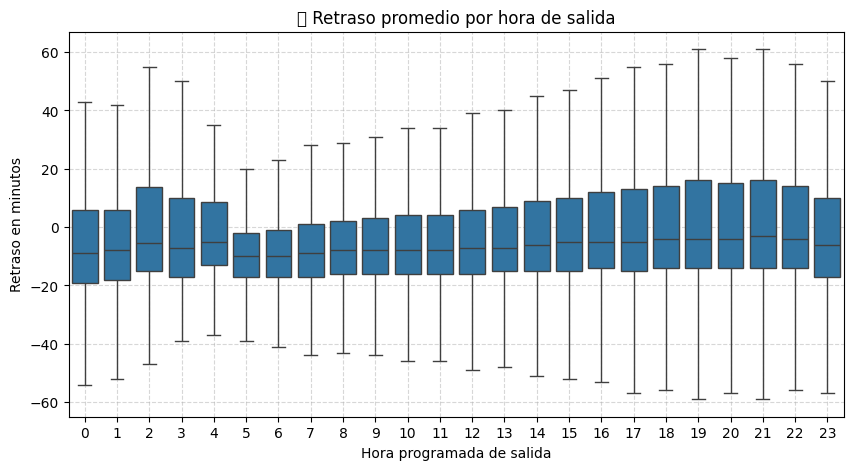

In [49]:
plt.figure(figsize=(10,5))
sns.boxplot(x='DEP_HOUR', y='ARR_DELAY', data=df, showfliers=False)
plt.title("⏰ Retraso promedio por hora de salida")
plt.xlabel("Hora programada de salida")
plt.ylabel("Retraso en minutos")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


/tmp/ipykernel_5635/3062183957.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MONTH', y='ARR_DELAY', data=df, palette='coolwarm')
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


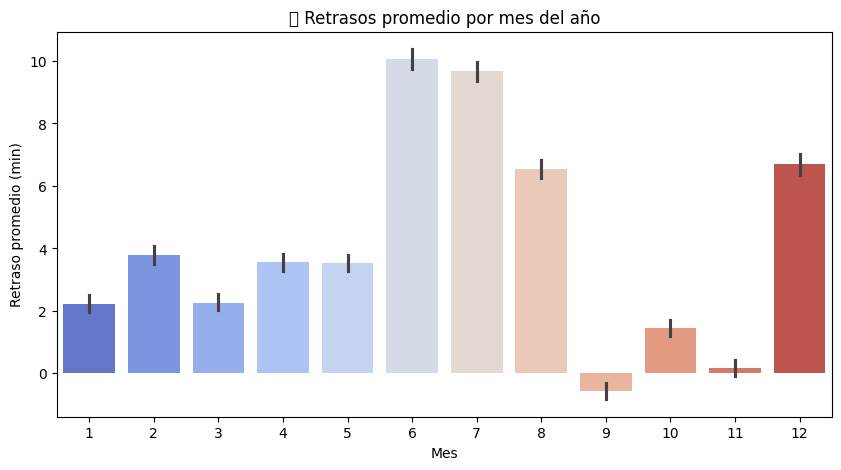

In [50]:
plt.figure(figsize=(10,5))
sns.barplot(x='MONTH', y='ARR_DELAY', data=df, palette='coolwarm')
plt.title("📅 Retrasos promedio por mes del año")
plt.xlabel("Mes")
plt.ylabel("Retraso promedio (min)")
plt.show()


In [51]:
#Cargar solo columnas necesarias del CSV original
df_raw = pd.read_csv("../data/flight_delays_sample.csv", usecols=['ORIGIN', 'DEST', 'ARR_DELAY'])

#Seleccionar las rutas con más retrasos promedio
top_routes = (
    df_raw.groupby(['ORIGIN', 'DEST'])['ARR_DELAY']
    .mean()
    .reset_index()
    .sort_values('ARR_DELAY', ascending=False)
    .head(30)
)

#Cargar dataset de aeropuertos (OpenFlights)
airports = pd.read_csv(
    'https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat',
    header=None,
    names=['id','name','city','country','IATA','ICAO','lat','lon','alt','tz','dst','tz_db','type','source']
)

airports_us = airports[
    (airports['country'] == 'United States') &
    (airports['IATA'].notnull())
][['IATA', 'lat', 'lon']]

#Unir coordenadas de origen y destino
routes = (
    top_routes
    .merge(airports_us, left_on='ORIGIN', right_on='IATA')
    .merge(airports_us, left_on='DEST', right_on='IATA', suffixes=('_orig', '_dest'))
)


#Crear mapa con líneas entre aeropuertos
m_routes = folium.Map(location=[39.5, -98.35], zoom_start=4, tiles='cartodbpositron')

for _, row in routes.iterrows():
    folium.PolyLine(
        locations=[(row['lat_orig'], row['lon_orig']), (row['lat_dest'], row['lon_dest'])],
        color='red',
        weight=2 + (row['ARR_DELAY'] / routes['ARR_DELAY'].max()) * 4,  # grosor según retraso
        opacity=0.7
    ).add_to(m_routes)

#Guardar y mostrar mapa
m_routes.save('delay_routes.html')
m_routes


In [54]:
df.columns

Index(['AIRLINE', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_DELAY',
       'CRS_ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'DIVERTED',
       'CRS_ELAPSED_TIME', 'DISTANCE', 'DEP_HOUR', 'ARR_HOUR', 'IS_DELAYED',
       'DAY_OF_WEEK', 'MONTH', 'DAY'],
      dtype='object')